# This notebook provides a simple example that illustrates our proposed MCCS and null-space based methods for generating private audio zones

In [1]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import pyroomacoustics as pra
import scipy
from random import randint

import os
import pickle
import scipy.io.wavfile as wav

from utils import yield_speaker_listener_config, crop_signal, crop_start_end_rir, calculate_mccs_message_power

from optim import construct_Aty_regularized, construct_A_x_regularized, construct_A_x, solve_y_eq_Ax_mccs_regularized, solve_y_eq_Ax_nullspace_regularized, project_y_on_null_space_of_A
import IPython

import pystoi
from pystoi import stoi


In [2]:
#exp configuration

l1, l2 = 7, 8
room_dims = [l1,l2]   

num_speakers = 6
num_listeners = 2

room_config = {'num_speakers': 6,
              'num_listeners': 2,
              'room_dims': room_dims}


#obtain random coordinates for sources (speakers) and listeners
#one random location for an eavesdropper is generated

source_coordinates, listener_coordinates, eaves_coordinates = yield_speaker_listener_config(**room_config)


In [3]:
# load audio files
#we used 2s long audio signals in our numerical exps

all_audio = os.listdir('./test_audio_files/')

if len(all_audio)< num_listeners:
    raise Exception('Not enough audio files') 
    
signals = []

for name in all_audio:
    
    fs1, signal = wav.read('./test_audio_files/'+name)
    
    signal = crop_signal(signal, fs1)
    
    signals.append(signal)


Some example RIRs:



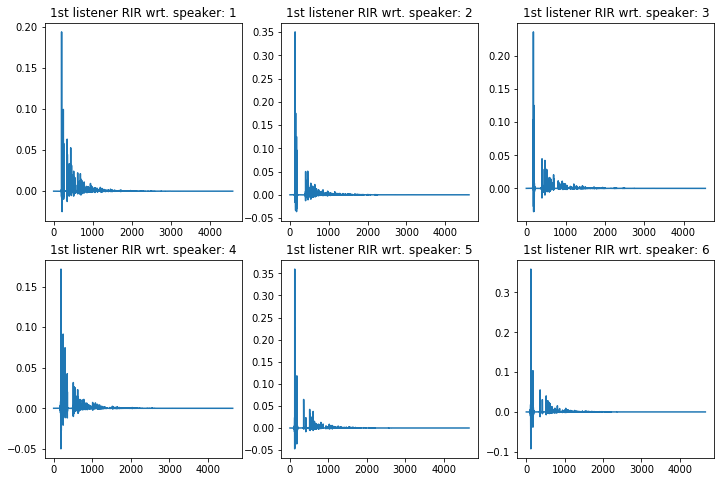

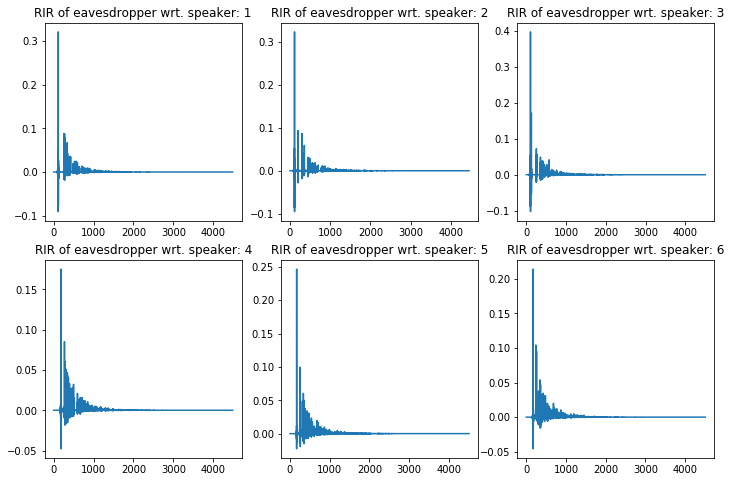

In [4]:
#construct room objects

room = pra.ShoeBox(room_dims, fs = fs1, absorption=0.35, max_order=17)

for i in range(num_speakers):
    room.add_source(source_coordinates[i])  

speakers = room.sources

# array locations for all points where RIR is needed. To evaluate intelligibility at eavesdropper's location, 
#we would need RIR at that location too.

R = np.concatenate((listener_coordinates.T, np.expand_dims(eaves_coordinates, axis = 1)), axis = 1)

listeners_with_eaves = pra.MicrophoneArray(R, room.fs) 

room.add_microphone_array(listeners_with_eaves)



# h_listeners is a list of length- num_listeners. Each element of the list contains RIRs wrt the speakers in the room 
# h_eaves simply contains the RIRs of speakers wrt a random eavesdropper location. This would be used during method evaluation

room.compute_rir()
h_listeners = room.rir[:-1]
h_eaves = room.rir[-1]

print('Some example RIRs:\n')
plt.figure(figsize = [12, 8])

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.plot(h_listeners[0][i])
    plt.title('1st listener RIR wrt. speaker: '+ str(i+1))
    

plt.figure(figsize = [12, 8])

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.plot(h_eaves[i])
    plt.title('RIR of eavesdropper wrt. speaker: '+ str(i+1))


# start_points, end_points, earliest_start, last_end = find_start_and_end_points(h_listeners, 0.92)  

The RIRs could be quite long due to lots of weak higher order reflections, though the most of the energy is supported in a small time interval. This results in a large number of near-zero entries at the end, which if not removed can make channel matrices ill-conditioned.

Additionally, while contructing the suitable message signals via optimization, we need to account for the time it takes for the earliest impulse to reach a listener from the speakers. This can be done by suitable padding the signals we desire to arrive at the listeners, or cropping the RIRs during construction of message signals.

In this notebook, we crop the RIRs during message construction.

Time index when 92% of all RIR energy has been received for a specific listener-speaker pair:  451
Time index when 99% of all RIR energy has been received for a specific listener-speaker pair:  835


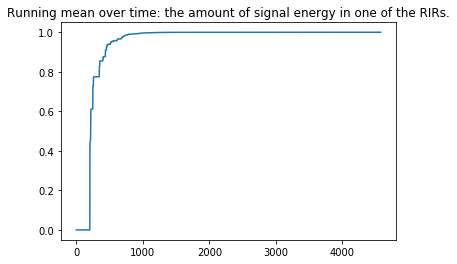

In [5]:
h_listener1_1 = h_listeners[0][0] 
running_mean_energy = np.cumsum(h_listener1_1**2)/np.sum(h_listener1_1**2)
plt.plot(running_mean_energy)
plt.title('Running mean over time: the amount of signal energy in one of the RIRs.')

print('Time index when 92% of all RIR energy has been received for a specific listener-speaker pair: ', np.argmax(running_mean_energy>0.92))
print('Time index when 99% of all RIR energy has been received for a specific listener-speaker pair: ', np.argmax(running_mean_energy>0.99))

# L_h has been chosen here as a ballpark to crop RIRs for conditioning. 
# One can also find it adaptively depending upon the speaker-listener configuration, room size and wall reflection properties
L_h = 500


In [6]:
# for each listener find the arrival time of the earliest arriving peak
# Also, crop the RIRs suitably to improve matrix conditioning

h_listeners, h_eaves = crop_start_end_rir(h_listeners, h_eaves, L_h = L_h)


#each signal is 2s long
N = len(signals[0])

# length of message signals
L_x=N-L_h+1



# Construct messages for the two methods

Since the number of speakers is larger than the number of target listeners, the channel matrix used in optimization is a fat matrix. Therefore, **multiple possible message signals** can be used to generate the signal desired at the target listener's locations.

A desirable choice for input message signal is the one with low l-2 norm. We use a **Tikhonov regularizer** to impose this property.

Note that owing to the large size of RIRs, we do not explicitly construct Toeplitz channel matrices. Instead, the minimization is performed efficiently with FFTs.





# MCCS approach

In [7]:
# MCCS approach sends filtered noise to construct audio. The size of noise and filters is determined by max_param
max_param = (1 - N*num_listeners/(num_speakers*L_x))
max_param = max_param-0.05



# length of noise signal
L_n = int(np.ceil(max_param * L_x))  -1

# length of filter 
L_g = L_x - L_n + 1

print('Length of noise signals used in MCCS approach: ', L_n)
print('Length of filters with which noise is convolved: ', L_g)

Length of noise signals used in MCCS approach:  13123
Length of filters with which noise is convolved:  8429


In [8]:
H_with_noise_list = []
H_eaves_with_noise_list = []
Noise = []

signals = np.concatenate(signals, axis = 0)


# sample noise. chosen variance of these noise signals is irrelevant.
for p in range(num_speakers):
    Noise.append(20*np.random.randn(L_n))
    

for i in range(num_listeners):

    H_with_noise_temp = []
    for j in range(num_speakers):
        
        H_with_noise_temp.append(np.convolve(Noise[j], h_listeners[i][j]))

    H_with_noise_list.append(H_with_noise_temp)
    

H_eaves_with_noise_list = [[np.convolve(h_eaves[j], Noise[j]) for j in range(num_speakers)]]
 
    


**Construct filters needed to convolve noise signals at each speaker**



In [73]:
#tikhonov regularization parameter
tikhonov_param = 1e-5

np.random.seed(0)


In [74]:
# lambda_v is a Tikhonov regularization parameter. 
# Setting very low values results in large message power, though with slight improvements in audio reconstruction.

mccs_optim_variables = {'y': signals,
                       'H_with_noise_matrix': H_with_noise_list,
                       'Noise_matrix': Noise,
                       'L_g': L_g,
                       'L_n': L_n,
                       'N': N,
                       'lambda_v': tikhonov_param,
                       'num_iter': 100}


# set of filters used for convolving with noise
g_filter = solve_y_eq_Ax_mccs_regularized(**mccs_optim_variables)


#sound received at different listeners
recon = construct_A_x(H_with_noise_list, g_filter, L_g, N)
recon_error = np.linalg.norm(recon - signals)**2/np.prod(recon.shape)

#sound received at eavesdropper
recon_eaves = construct_A_x(H_eaves_with_noise_list, g_filter, L_g, N)


total_mccs_message_power = calculate_mccs_message_power(g_filter, Noise, L_g)

print('Reconstruction error: ', recon_error)
print('Total MCCS message power: ', total_mccs_message_power)


Reconstruction error:  425.58383631231226
Total MCCS message power:  276692.1776879572


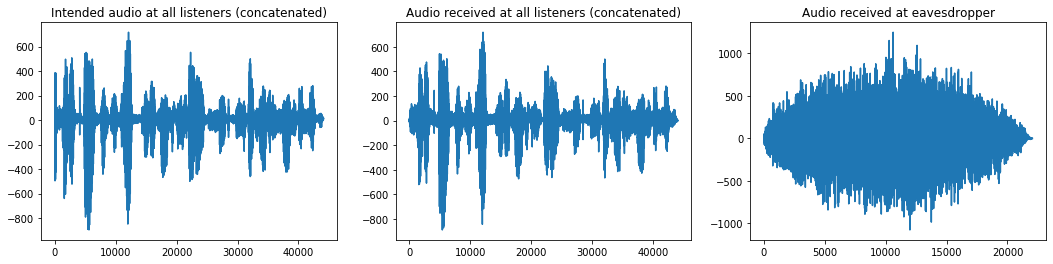

In [75]:
plt.figure(figsize = [18, 4])

plt.subplot(1, 3, 1)
plt.plot(signals)
plt.title('Intended audio at all listeners (concatenated)')

plt.subplot(1, 3, 2)
plt.plot(recon)
plt.title('Audio received at all listeners (concatenated)')

plt.subplot(1, 3, 3)
plt.plot(recon_eaves)
plt.title('Audio received at eavesdropper')


wav.write(filename = './mccs_reconstructions/recon_eaves.wav', rate = fs1, data = recon_eaves.astype('int16') )

for i in range(1, num_listeners+1):
    wav.write(filename = './mccs_reconstructions/recon'+str(i)+'.wav', rate = fs1, data = recon.astype('int16')[i*N : (i+1)*N])
    wav.write(filename = './mccs_reconstructions/orig'+str(i)+'.wav', rate = fs1, data = signals[i*N:(i+1)*N]  )



# Null space method






**First construct message signals**

In [76]:
H_list = h_listeners
H_eaves_list = [h_eaves]
null_space_optim_variables = {'y': signals,
                       'H_matrix': H_list,
                       'L_x': L_x,
                       'N': N,
                       'lambda_v': tikhonov_param,
                       'num_iter': 100}


# set of messages to be transmitted by loudspeaker (in the absence of noise)
g_message = solve_y_eq_Ax_nullspace_regularized(**null_space_optim_variables)

null_space_message_power = np.linalg.norm(g_message)**2/np.prod(g_message.shape)


print('Message power (without noise): ', null_space_message_power)


Message power (without noise):  3006.812708575833


**Add noise to the null space of H matrix**

Once the message signals are constructed, we can add arbitrary amount of noise after projecting it onto the null space of H matrix. However, this could result in large amounts of input power at loud speaker, and result in an unfair comparison with MCCS method in terms of their jamming abilities. 

Therefore, for fairness, we add noise in a way to ensure equal input loud speaker power for both MCCS and null space methods.

In [77]:
total_noise_power_possible = total_mccs_message_power - null_space_message_power


noise = np.random.randn(len(g_message))

projection_variables = {'y': noise,
                       'A': H_list,
                        'L_x': L_x,
                        'N': N,
                        'num_iter': 100}

noise_null_space_projection = project_y_on_null_space_of_A(**projection_variables)
noise_null_space_power = np.linalg.norm(noise_null_space_projection)**2/len(noise_null_space_projection)
noise_null_space_projection = noise_null_space_projection*np.sqrt(total_noise_power_possible*0.65)/(noise_null_space_power)
total_additive_power=(np.linalg.norm(g_message+noise_null_space_projection))**2/len(g_message+noise_null_space_projection)

print('\nTotal filtered power: ', total_mccs_message_power)
print('Total additive power: ', total_additive_power)
print('filtered/additive ratio: ',total_mccs_message_power/total_additive_power)
print()


#add null space projected noise to the message signal. This total signal is now transmitted from loudspeakers
g_null_space = g_message + noise_null_space_projection


#sound received at different listeners
recon_null_space = construct_A_x(H_list, g_null_space, L_x, N)
recon_null_space_error = np.linalg.norm(recon_null_space - signals)**2/np.prod(recon.shape)


#sound received at eavesdropper
recon_eaves_null_space = construct_A_x(H_eaves_list, g_null_space, L_x, N)

print('Reconstruction error (null space): ', recon_null_space_error)
print('Total input power of signal played by speaker: ', np.linalg.norm(g_null_space)**2/np.prod(g_null_space.shape))



Total filtered power:  276692.1776879572
Total additive power:  273816.97391956195
filtered/additive ratio:  1.0105004584896182

Reconstruction error (null space):  44.748264744224734
Total input power of signal played by speaker:  273816.97391956195


In [78]:


wav.write(filename = './null_space_method_reconstructions/recon_eaves.wav', rate = fs1, data = recon_eaves_null_space.astype('int16') )

for i in range(1, num_listeners+1):
    wav.write(filename = './null_space_method_reconstructions/recon'+str(i)+'.wav', rate = fs1, data = recon_null_space.astype('int16')[i*N : (i+1)*N])
    wav.write(filename = './null_space_method_reconstructions/orig'+str(i)+'.wav', rate = fs1, data = signals[i*N:(i+1)*N]  )



Text(0.5, 1.0, 'Audio received at eavesdropper')

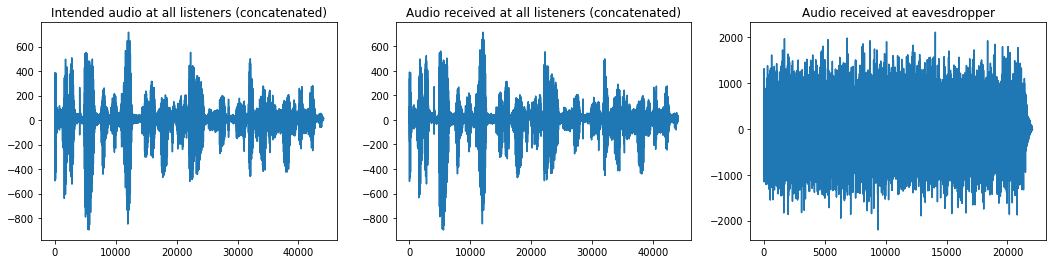

In [79]:
plt.figure(figsize = [18, 4])

plt.subplot(1, 3, 1)
plt.plot(signals)
plt.title('Intended audio at all listeners (concatenated)')

plt.subplot(1, 3, 2)
plt.plot(recon_null_space)
plt.title('Audio received at all listeners (concatenated)')

plt.subplot(1, 3, 3)
plt.plot(recon_eaves_null_space)
plt.title('Audio received at eavesdropper')

# Compare STOI of reconstructions for the two methods

STOI below 0.4 typically indicates speech unintelligibility

**For null space approach**

In [80]:

stoi_listener_list = []
for i in range(num_listeners):
    stoi_listener = stoi(signals[i*N:(i+1)*N], recon_null_space[i*N:(i+1)*N], fs1, extended=False)
    
    stoi_listener_list.append(stoi_listener)
    

stoi_eaves1 = stoi(signals[0:N], recon_eaves_null_space, fs1, extended=False)
stoi_eaves2 = stoi(signals[N:2*N], recon_eaves_null_space, fs1, extended=False)


print('STOI at different listeners: ', stoi_listener_list)
print('STOI at eavesdropper: ', stoi_eaves1, stoi_eaves2)


STOI at different listeners:  [0.9918780510252148, 0.970982322892965]
STOI at eavesdropper:  0.20309874211867088 0.1103209999700949


**For MCCS approach**

In [81]:

stoi_listener_mccs_list = []
for i in range(num_listeners):
    stoi_listener = stoi(signals[i*N:(i+1)*N], recon[i*N:(i+1)*N], fs1, extended=False)
    
    stoi_listener_mccs_list.append(stoi_listener)
    

stoi_eaves1 = stoi(signals[0:N], recon_eaves, fs1, extended=False)
stoi_eaves2 = stoi(signals[N:2*N], recon_eaves, fs1, extended=False)


print('STOI at different listeners: ', stoi_listener_list)
print('STOI at eavesdropper: ', stoi_eaves1, stoi_eaves2)


STOI at different listeners:  [0.9918780510252148, 0.970982322892965]
STOI at eavesdropper:  0.2515559487969814 0.14326506102110645
